In [2]:
import pandas as pd
import sqlalchemy as sa

engine = sa.create_engine("mssql+pyodbc:///?odbc_connect= DRIVER={SQL Server};SERVER=mph-eprprddwh1\DWHPRD;Trusted_Connection=yes;")

with engine.connect() as conn:
   refs_df = pd.read_sql(open("S:\Data Science\sandboxes\Jawad\patient_LOS_project\patient_los_elect.sql").read(), con=conn.connection)

<>:4: SyntaxWarning: invalid escape sequence '\D'
<>:7: SyntaxWarning: invalid escape sequence '\D'
<>:4: SyntaxWarning: invalid escape sequence '\D'
<>:7: SyntaxWarning: invalid escape sequence '\D'
C:\Users\jawad.iqbal\AppData\Local\Temp\ipykernel_13872\2837943426.py:4: SyntaxWarning: invalid escape sequence '\D'
  engine = sa.create_engine("mssql+pyodbc:///?odbc_connect= DRIVER={SQL Server};SERVER=mph-eprprddwh1\DWHPRD;Trusted_Connection=yes;")
C:\Users\jawad.iqbal\AppData\Local\Temp\ipykernel_13872\2837943426.py:7: SyntaxWarning: invalid escape sequence '\D'
  refs_df = pd.read_sql(open("S:\Data Science\sandboxes\Jawad\patient_LOS_project\patient_los_elect.sql").read(), con=conn.connection)
C:\Users\jawad.iqbal\AppData\Local\Temp\ipykernel_13872\2837943426.py:7: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  refs_df = pd.read_sq

In [10]:
df_elect = refs_df.copy()

In [11]:
len(df_elect)

2423

In [12]:
refs_df.isna().sum()

admission_datetime          0
weekend                     0
time_of_day                 0
DischargeDestination        0
WardAdmission               0
Los                         0
PriorityType              443
IntendedManagement          0
AdmissionMethod             0
SourceOfAdmission           0
em_el_dc                    0
EthnicCategory            129
AgeOnAdmission              0
StartSexofPatientsCode      0
PrimaryDiagnosisICD         0
Description                 0
Chapter_Number              0
Chapter_Description         0
IMD_Decile                  0
dtype: int64

In [13]:
df_elect.head(5)

,admission_datetime,weekend,time_of_day,DischargeDestination,WardAdmission,Los,PriorityType,IntendedManagement,AdmissionMethod,SourceOfAdmission,em_el_dc,EthnicCategory,AgeOnAdmission,StartSexofPatientsCode,PrimaryDiagnosisICD,Description,Chapter_Number,Chapter_Description,IMD_Decile
0,2018-01-08 12:21:38.173,1,Afternoon,19,Cardiac Catheter Laboratory,0,2.4,2,11,19,ELECT,A,58,1,R074,"Chest pain, unspecified",18,"Symptoms, signs and abnormal clinical and labo...",3.0
1,2018-01-10 13:39:07.307,0,Afternoon,19,Cardiac Catheter Laboratory,0,None,4,13,19,ELECT,A,73,2,I480,Paroxysmal atrial fibrillation,9,Diseases of the circulatory system,4.0
2,2018-02-09 08:25:37.413,0,Morning,19,Cardiac Catheter Laboratory,2,None,2,13,19,ELECT,A,69,1,I240,Coronary thrombosis not resulting in myocardia...,9,Diseases of the circulatory system,7.0
3,2018-02-14 12:25:45.660,0,Afternoon,19,Cardiac Catheter Laboratory,2,1.3,1,11,19,ELECT,A,80,2,I442,"Atrioventricular block, complete",9,Diseases of the circulatory system,8.0
4,2018-02-14 12:25:45.660,0,Afternoon,19,Cardiac Catheter Laboratory,2,2.8,1,11,19,ELECT,A,80,2,I442,"Atrioventricular block, complete",9,Diseases of the circulatory system,8.0


<Axes: xlabel='Los', ylabel='Count'>

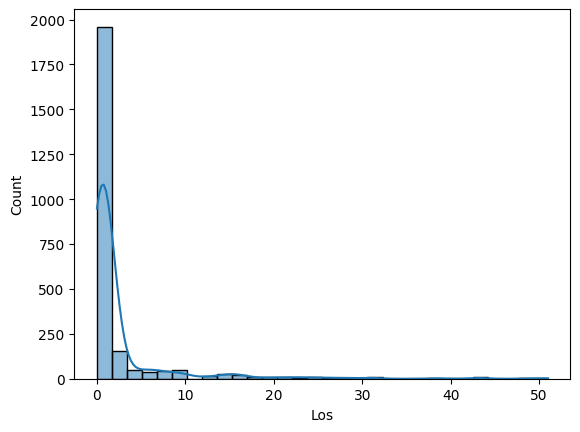

In [18]:
import seaborn as sns
sns.histplot(df_elect['Los'], bins=30, kde=True)


In [73]:
data['time_of_day'] = data['time_of_day'].map({'Morning':1, 'Afternoon':2, 'Evening':3, 'Midnight':4})

In [74]:
data.head(5)

,admission_datetime,weekend,time_of_day,WardAdmission,Los,PriorityType,IntendedManagement,AdmissionMethod,SourceOfAdmission,em_el_dc,EthnicCategory,AgeOnAdmission,StartSexofPatientsCode,PrimaryDiagnosisICD,Description,Chapter_Number,Chapter_Description,IMD_Decile
0,2022-05-12 08:23:00.000,0,1,Cardiac Catheter Laboratory,0,3,2,11,19,ELECT,A,76,1,I251,Atherosclerotic heart disease,9,Diseases of the circulatory system,5.0
1,2021-01-25 12:35:44.307,1,2,Cardiac Catheter Laboratory,0,1.3,1,11,19,ELECT,A,64,1,I251,Atherosclerotic heart disease,9,Diseases of the circulatory system,8.0
2,2023-10-06 08:15:00.000,0,1,Cardiac Catheter Laboratory,1,2.8,2,11,19,ELECT,A,74,2,I251,Atherosclerotic heart disease,9,Diseases of the circulatory system,6.0
7,2022-05-19 11:49:28.730,0,1,Cardiac Catheter Laboratory,1,1.3,2,11,19,ELECT,A,67,2,I251,Atherosclerotic heart disease,9,Diseases of the circulatory system,8.0
9,2023-12-04 11:18:10.743,1,1,Montacute Ward,18,3,1,11,19,ELECT,A,70,1,I214,Acute subendocardial myocardial infarction,9,Diseases of the circulatory system,7.0


In [75]:

data['month'] = data['admission_datetime'].dt.to_period('M').dt.to_timestamp()

In [76]:
avg_los_month = data.groupby('month')['Los'].mean().reset_index()
avg_los_month1 = data.groupby('month')['Los'].median().reset_index()

In [77]:
import pandas as pd
import plotly.graph_objects as go


# Create the plot
fig = go.Figure()
fig.add_trace(
    go.Scatter(
        x=avg_los_month['month'],
        y=avg_los_month['Los'],
        mode='lines+markers',
        name='Average LOS mean',
        line=go.scatter.Line(shape='spline')
    )
)

fig.add_trace(
    go.Scatter(
        x=avg_los_month1['month'],
        y=avg_los_month1['Los'],
        mode='lines+markers',
        name='Average LOS median',
        line=go.scatter.Line(shape='spline')
    )
)

# Update layout
fig.update_layout(
    title='Average LOS Per Month (2021–2024) - ELECT',
    xaxis_title='Month',
    yaxis_title='Length of Stay (Days)',
    template='plotly_white',
    margin=dict(l=20, r=20, t=40, b=40),
    xaxis=dict(tickangle=50)
)

fig.show()


In [59]:
data[data['month'] == 'May 2020'][data['Los'] == 36]

C:\Users\jawad.iqbal\AppData\Local\Temp\ipykernel_8080\3930249456.py:1: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.



,admission_datetime,weekend,time_of_day,WardAdmission,Los,PriorityType,IntendedManagement,AdmissionMethod,SourceOfAdmission,em_el_dc,EthnicCategory,AgeOnAdmission,StartSexofPatientsCode,PrimaryDiagnosisICD,Description,Chapter_Number,Chapter_Description,IMD_Decile,month
267,2020-05-25 14:19:24.030,1,Afternoon,Parkside Ward,36,2,1,12,19,ELECT,A,74,2,I500,Congestive heart failure,9,Diseases of the circulatory system,6.0,2020-05-01
399,2020-05-25 14:19:24.030,1,Afternoon,Parkside Ward,36,2.1,2,12,19,ELECT,A,74,2,I500,Congestive heart failure,9,Diseases of the circulatory system,6.0,2020-05-01
419,2020-05-25 14:19:24.030,1,Afternoon,Parkside Ward,36,3.3,1,12,19,ELECT,A,74,2,I500,Congestive heart failure,9,Diseases of the circulatory system,6.0,2020-05-01
3520,2020-05-25 14:19:24.030,1,Afternoon,Parkside Ward,36,2,1,12,19,ELECT,A,74,2,E871,Hypo-osmolality and hyponatraemia,4,"Endocrine, nutritional and metabolic diseases",6.0,2020-05-01
3524,2020-05-25 14:19:24.030,1,Afternoon,Parkside Ward,36,2.1,2,12,19,ELECT,A,74,2,E871,Hypo-osmolality and hyponatraemia,4,"Endocrine, nutritional and metabolic diseases",6.0,2020-05-01
3527,2020-05-25 14:19:24.030,1,Afternoon,Parkside Ward,36,3.3,1,12,19,ELECT,A,74,2,E871,Hypo-osmolality and hyponatraemia,4,"Endocrine, nutritional and metabolic diseases",6.0,2020-05-01


<Axes: xlabel='Los', ylabel='Count'>

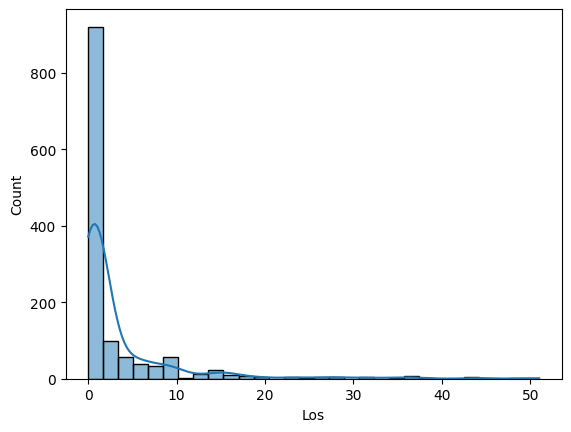

In [78]:

import seaborn as sns
sns.histplot(data['Los'], bins=30, kde=True)


In [80]:
data_filtered =  data.drop(columns=['admission_datetime' ,'em_el_dc','Description', 'Chapter_Description', 'WardAdmission'])

In [81]:
data_filtered['month'] = data_filtered['month'].dt.month

In [87]:
len(data_filtered['PrimaryDiagnosisICD'].unique())

81

In [89]:
import optuna
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import TransformedTargetRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

from xgboost import XGBRegressor

#Feature List
num_cols = ['AgeOnAdmission']
low_card_cols = ['AdmissionMethod','SourceOfAdmission','EthnicCategory','Chapter_Number' ,'IMD_Decile','month','weekend','StartSexofPatientsCode','time_of_day', 'IntendedManagement', 'PriorityType']
high_card_cols = ['PrimaryDiagnosisICD']

#Preprocessing Pipelines
num_pipe = Pipeline([
    ('scaler', StandardScaler())
])
low_card_pipe = Pipeline([
    ('ohe', OneHotEncoder(handle_unknown='ignore'))
])


high_card_pipe = Pipeline([
    ('ohe', OneHotEncoder(handle_unknown='ignore', max_categories=250))
])

preprocessor = ColumnTransformer([
    ('num', num_pipe, num_cols),
    ('low_ohe', low_card_pipe, low_card_cols),
    ('high_ohe', high_card_pipe, high_card_cols)
])

#Data Split
target_col = 'Los'
X = data_filtered.drop(columns=[target_col])
y = data_filtered[target_col]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

#Optuna Objective Function
def objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-3, 10.0, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-3, 10.0, log=True),
        'random_state': 42,
        'n_jobs': -1
    }

    xgb = XGBRegressor(**params)

    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('model', xgb)
    ])

    regressor = TransformedTargetRegressor(
        regressor=pipeline,
        func=np.log1p,
        inverse_func=np.expm1
    )

    regressor.fit(X_train, y_train)
    y_pred = regressor.predict(X_test)
    return mean_squared_error(y_test, y_pred)

#Run Optuna Study
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50)

print("Best trial params:", study.best_trial.params)

#Train Final Model
best_params = study.best_trial.params
final_model = Pipeline([
    ('preprocessor', preprocessor),
    ('model', XGBRegressor(**best_params))
])

regressor = TransformedTargetRegressor(
    regressor=final_model,
    func=np.log1p,
    inverse_func=np.expm1
)

regressor.fit(X_train, y_train)
y_pred = regressor.predict(X_test)

r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred)

print(f"Final Test MAE: {mae:.3f}, RMSE: {rmse:.3f}, R² Score: {r2:.4f}")


[I 2025-08-13 15:32:41,693] A new study created in memory with name: no-name-9a6d3bd5-f9f9-4bdf-b71d-97f278b51c97
[I 2025-08-13 15:32:42,411] Trial 0 finished with value: 26.73621940612793 and parameters: {'n_estimators': 894, 'max_depth': 9, 'learning_rate': 0.03244210154553448, 'subsample': 0.535086132989477, 'colsample_bytree': 0.5837044746552418, 'reg_alpha': 6.033070011115304, 'reg_lambda': 0.7930546154258854}. Best is trial 0 with value: 26.73621940612793.
[I 2025-08-13 15:32:42,563] Trial 1 finished with value: 27.92865562438965 and parameters: {'n_estimators': 236, 'max_depth': 6, 'learning_rate': 0.04838635910049754, 'subsample': 0.5609931887200288, 'colsample_bytree': 0.8970092548341653, 'reg_alpha': 3.303628613900889, 'reg_lambda': 0.3861111978096893}. Best is trial 0 with value: 26.73621940612793.
[I 2025-08-13 15:32:43,026] Trial 2 finished with value: 27.00730323791504 and parameters: {'n_estimators': 959, 'max_depth': 5, 'learning_rate': 0.013077168332911594, 'subsample'

Best trial params: {'n_estimators': 933, 'max_depth': 7, 'learning_rate': 0.23337233997134246, 'subsample': 0.514345275195242, 'colsample_bytree': 0.5552444958233566, 'reg_alpha': 0.0014271301564419052, 'reg_lambda': 5.463398368193721}
Final Test MAE: 1.308, RMSE: 8.863, R² Score: 0.7937


In [90]:
import pandas as pd
import sqlalchemy as sa

engine = sa.create_engine("mssql+pyodbc:///?odbc_connect= DRIVER={SQL Server};SERVER=mph-eprprddwh1\DWHPRD;Trusted_Connection=yes;")

with engine.connect() as conn:
   test_df = pd.read_sql(open("S:\Data Science\sandboxes\Jawad\patient_LOS_project\elect_test_sql.sql").read(), con=conn.connection)

<>:4: SyntaxWarning:

invalid escape sequence '\D'

<>:7: SyntaxWarning:

invalid escape sequence '\D'

<>:4: SyntaxWarning:

invalid escape sequence '\D'

<>:7: SyntaxWarning:

invalid escape sequence '\D'

C:\Users\jawad.iqbal\AppData\Local\Temp\ipykernel_8080\2955129477.py:4: SyntaxWarning:

invalid escape sequence '\D'

C:\Users\jawad.iqbal\AppData\Local\Temp\ipykernel_8080\2955129477.py:7: SyntaxWarning:

invalid escape sequence '\D'

C:\Users\jawad.iqbal\AppData\Local\Temp\ipykernel_8080\2955129477.py:7: UserWarning:

pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.



In [91]:
len(test_df)

459

In [94]:
test_elect = test_df.copy()

In [95]:
test_elect = test_elect.drop_duplicates()

In [96]:
test_elect = test_elect.dropna()

In [97]:
test_elect = test_elect.drop(columns=['admission_datetime'])

In [98]:
len(test_elect)

162

In [103]:
test_elect['time_of_day'].value_counts()

time_of_day
2    99
1    63
Name: count, dtype: int64

In [101]:
elect_predictions = regressor.predict(test_elect)

In [104]:
t_r2 = r2_score(test_elect['Los'], elect_predictions)
t_mae = mean_absolute_error(test_elect['Los'], elect_predictions)
t_rmse = np.sqrt(mean_squared_error(test_elect['Los'], elect_predictions))

print(f"Unseen Test MAE: {t_mae:.3f}, RMSE: {t_rmse:.3f}, R² Score: {t_r2:.4f}")

Unseen Test MAE: 2.248, RMSE: 4.304, R² Score: -0.7770


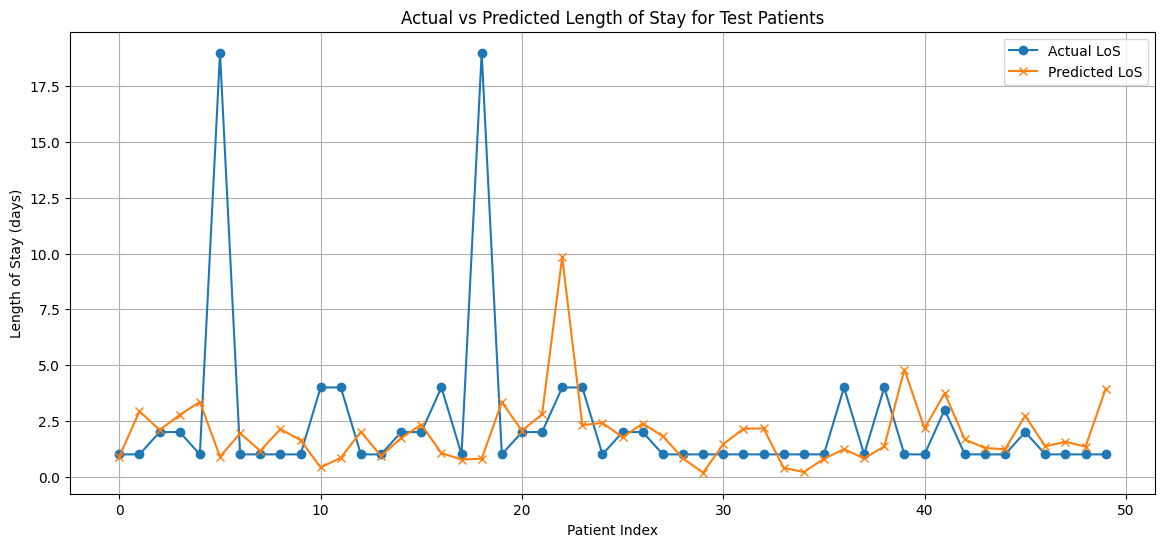

In [105]:

import matplotlib.pyplot as plt
import numpy as np

# Convert to numpy arrays for indexing
y_test_array = np.array(test_elect['Los'][:50])
y_pred_array = np.array(elect_predictions[:50])

# Create an index for each patient
indices = np.arange(len(y_test_array))

# Plot actual vs predicted as line plot
plt.figure(figsize=(14, 6))
plt.plot(indices, y_test_array, label='Actual LoS', marker='o')
plt.plot(indices, y_pred_array, label='Predicted LoS', marker='x')
plt.xlabel('Patient Index')
plt.ylabel('Length of Stay (days)')
plt.title('Actual vs Predicted Length of Stay for Test Patients')
plt.legend()
plt.grid(True)
